Load packages

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


Load in data

In [221]:
# Load in csv
df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')
df.index = pd.to_datetime(df['event_date']) # Index the event_date column and convert it to a datetime object
df.drop(['Unnamed: 0', 'event_date', 'event_name', 'activity_name', 'fiscal', 'def_price_code', 'quality', 'direction', 'player_tunnel'], axis=1, inplace=True) # Drop columns that arent needed
df.head()

C:\Users\tmanett\AppData\Local\Temp\ipykernel_8696\3818821012.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')


,section_name,row_name,seat_num,tier,bowl_level,view_level,side_level,row_number,section_number,penalty_box,...,section_index,row_index,team,price_code_desc,price_diff_perc,price_diff_doll,resale_price,face_value,resale_price_outlier,price_diff_perc_outlier
event_date,,,,,,,,,,,,,,,,,,,,,
2016-02-18,101,15,17,5,Lower Bowl,Corners,Defend Side,15,101,False,...,0.517241,0.500000,New York Rangers,Light Gold,-0.059406,-12.0,190.0,202,no,no
2016-02-18,101,15,18,5,Lower Bowl,Corners,Defend Side,15,101,False,...,0.517241,0.529412,New York Rangers,Light Gold,-0.059406,-12.0,190.0,202,no,no
2016-02-18,101,9,1,5,Lower Bowl,Corners,Defend Side,9,101,False,...,0.310345,0.032258,New York Rangers,Plat Ends,-0.087678,-18.5,192.5,211,no,no
2016-02-18,101,9,2,5,Lower Bowl,Corners,Defend Side,9,101,False,...,0.310345,0.064516,New York Rangers,Plat Ends,-0.087678,-18.5,192.5,211,no,no
2016-02-25,101,27,13,5,Lower Bowl,Corners,Defend Side,27,101,False,...,0.931034,0.481481,Carolina Hurricanes,Club Ends,0.235669,37.0,194.0,157,no,no


In [222]:
def remove_numerical_outliers(df, threshold=1.5):
    # Filter numerical columns
    numerical_columns = df.select_dtypes(include=np.number).columns
    filtered_data = df.copy()

    for column in numerical_columns:
        data = df[column]
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        filtered_data = filtered_data[(filtered_data[column] >= lower_bound) & (filtered_data[column] <= upper_bound)]

    return filtered_data

df = remove_numerical_outliers(df)

In [223]:
column_names = df.columns.tolist()
print(column_names)

['section_name', 'row_name', 'seat_num', 'tier', 'bowl_level', 'view_level', 'side_level', 'row_number', 'section_number', 'penalty_box', 'bench', 'seat_class', 'aisle', 'section_index', 'row_index', 'team', 'price_code_desc', 'price_diff_perc', 'price_diff_doll', 'resale_price', 'face_value', 'resale_price_outlier', 'price_diff_perc_outlier']


Plot Y 

<Axes: title={'center': '% Delta of Resale Price and FV'}, xlabel='event_date'>

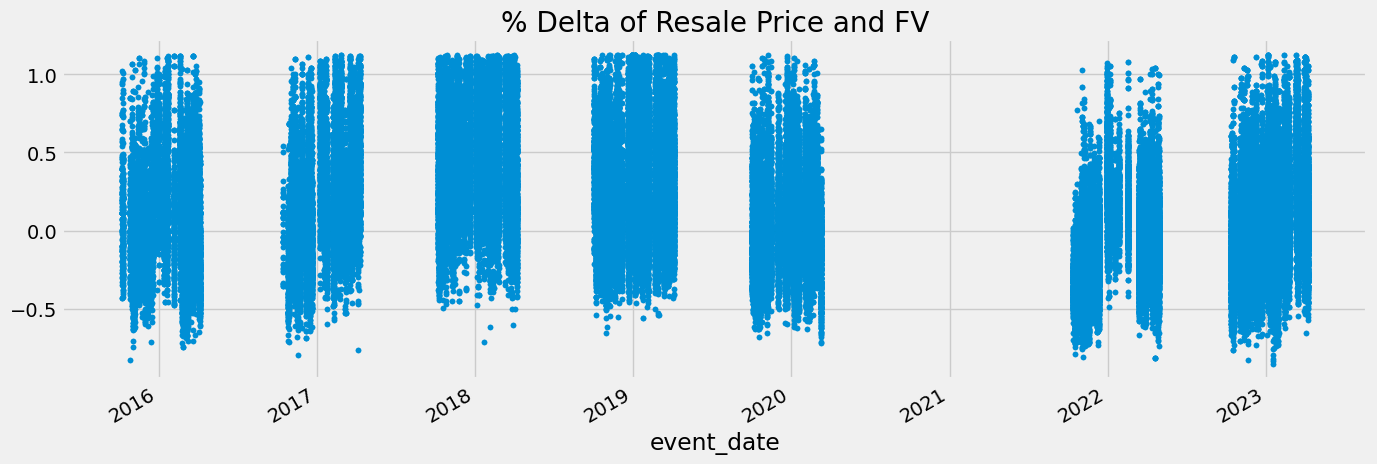

In [224]:
df['price_diff_perc'].plot(style='.', figsize=(15,5), color=color_pal[0], title='% Delta of Resale Price and FV')

In [225]:
df = pd.get_dummies(df, columns = ['bowl_level', 'view_level', 'side_level', 'team', "seat_class", "section_number", "row_number"])


In [226]:
column_names = df.columns.tolist()
print(column_names)

['section_name', 'row_name', 'seat_num', 'tier', 'penalty_box', 'bench', 'aisle', 'section_index', 'row_index', 'price_code_desc', 'price_diff_perc', 'price_diff_doll', 'resale_price', 'face_value', 'resale_price_outlier', 'price_diff_perc_outlier', 'bowl_level_Lower Bowl', 'bowl_level_Upper Bowl', 'view_level_Corners', 'view_level_Endzone', 'view_level_Sides', 'side_level_Attack Side', 'side_level_Center Ice', 'side_level_Defend Side', 'team_Anaheim Ducks', 'team_Arizona Coyotes', 'team_Boston Bruins', 'team_Buffalo Sabres', 'team_Calgary Flames', 'team_Carolina Hurricanes', 'team_Carolina Hurricanes ', 'team_Chicago Blackhawks', 'team_Chicago Blackhawks ', 'team_Colorado Avalanche', 'team_Columbus Blue Jackets', 'team_Dallas Stars', 'team_Detroit Red Wings', 'team_Edmonton Oilers', 'team_Florida Panthers', 'team_Los Angeles Kings', 'team_Minnesota Wild', 'team_Montreal Canadiens', 'team_Nashville Predators', 'team_New Jersey Devils', 'team_New Jersey Devils ', 'team_New York Islander

Train/Test Split

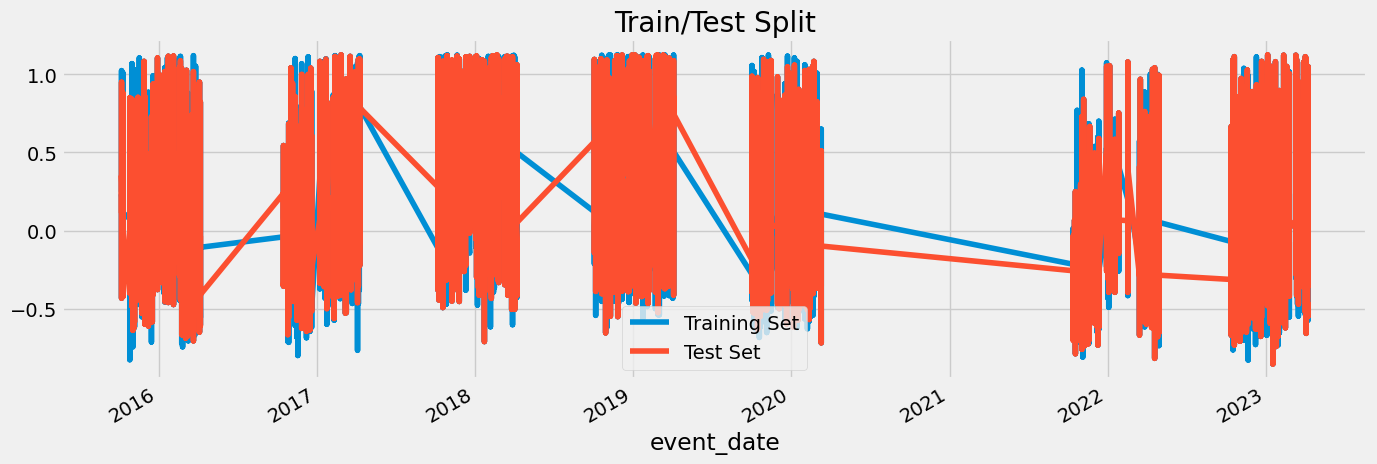

In [227]:
from sklearn.model_selection import train_test_split

df = df[['price_diff_perc', 'face_value','tier',  'section_index', 'row_index', "bowl_level_Lower Bowl", "aisle", 
    "bowl_level_Upper Bowl",
    "view_level_Corners",
    "view_level_Endzone",
    "view_level_Sides",
    "side_level_Attack Side",
    "side_level_Center Ice",
    "side_level_Defend Side" ,
 'seat_class_OBSTRUCTED', 'seat_class_STANDARD', 'seat_class_STANDING']]

# Split the data into training and test sets with a larger training set size
train, test = train_test_split(df, test_size=0.2, random_state=42)

fig, ax = plt.subplots(figsize=(15,5))
train['price_diff_perc'].plot(ax=ax, label='Training Set', title='Train/Test Split')
test['price_diff_perc'].plot(ax=ax, label='Test Set')
ax.legend()
plt.show()

One Week

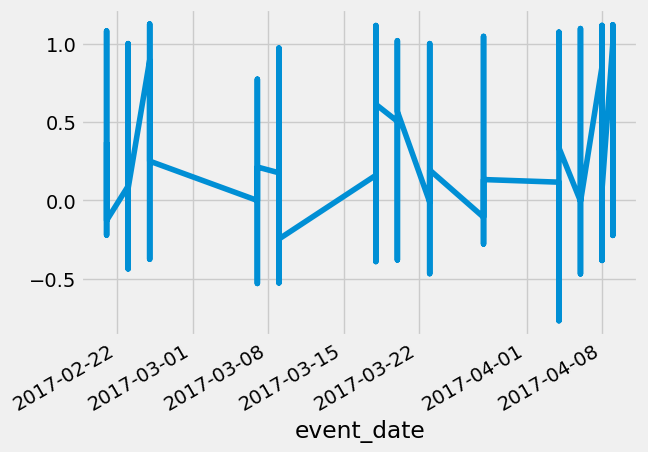

In [228]:
# Assuming your dataset is stored in a DataFrame called 'data'
df = df.loc[:, ~df.columns.duplicated()]

df['price_diff_perc'].loc[(df.index > '2017-02-18') & (df.index < '2017-08-25')].plot()
plt.show()

Feature Creation

In [229]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

One-Hot Encoding

Visualize our Feature/Target Relationship

<Axes: xlabel='month', ylabel='price_diff_perc'>

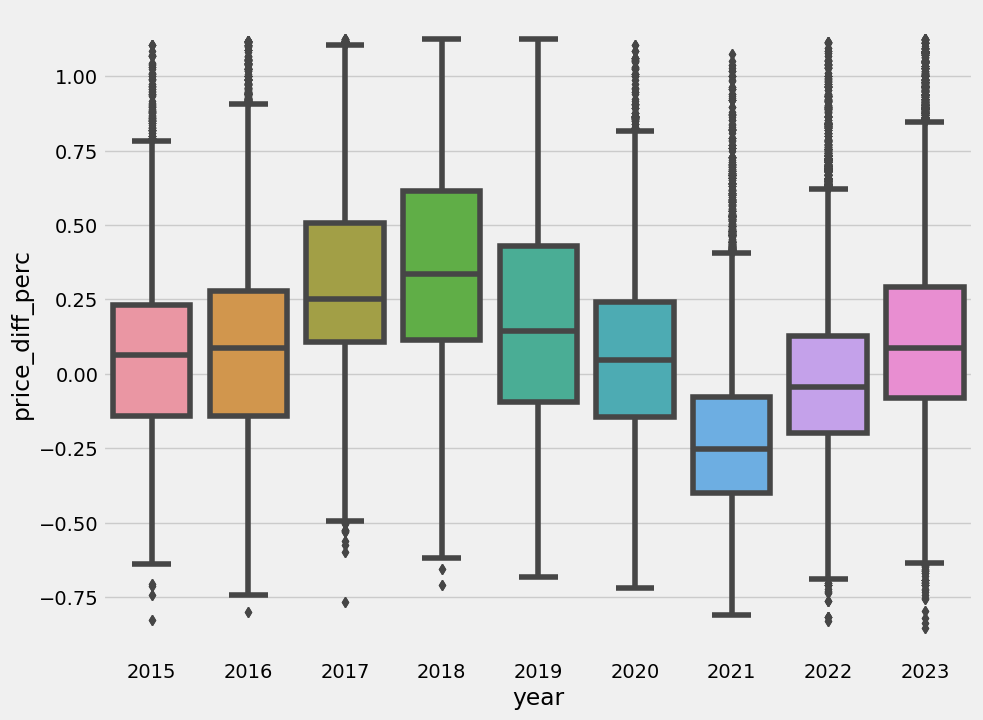

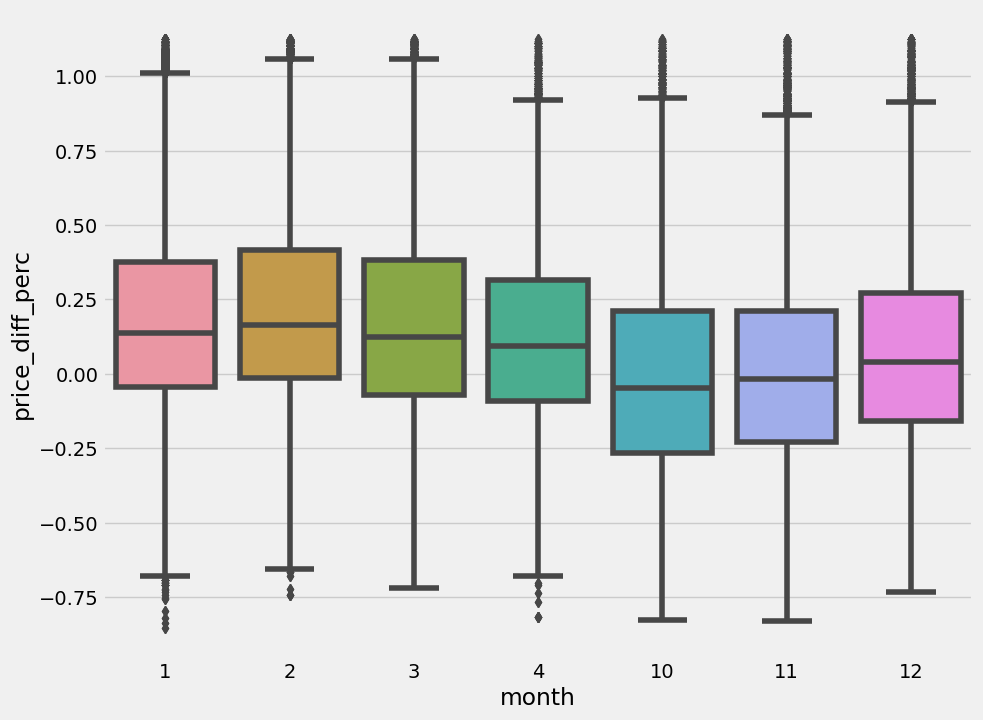

In [230]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='year', y='price_diff_perc')

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='price_diff_perc')

Model

In [231]:


FEATURES = ['face_value', 'tier',  'section_index', 'row_index', "bowl_level_Lower Bowl", 'aisle', 
    "view_level_Corners",
    "view_level_Endzone",
    "view_level_Sides",
    "side_level_Attack Side",
    "side_level_Center Ice",
    "side_level_Defend Side",
    'seat_class_OBSTRUCTED', 'seat_class_STANDARD', 'seat_class_STANDING'
    ]
TARGET = 'price_diff_perc'

In [232]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]



In [233]:

# Check for and handle zero values in target variable
epsilon = 0.001  # Small constant to add
y_train_no_zeros = np.where(y_train == 0, epsilon, y_train)
y_test_no_zeros = np.where(y_test == 0, epsilon, y_test)

# Create XGBoost regressor with updated parameters
reg = xgb.XGBRegressor(
    n_estimators=3000,
    early_stopping_rounds=100,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=0.5,
    reg_alpha=0.001,
    reg_lambda=0.1,
    gamma=0.2,
    min_child_weight=3
)

# Fit the model with the updated target variable
reg.fit(
    X_train, y_train_no_zeros,
    eval_set=[(X_train, y_train_no_zeros), (X_test, y_test_no_zeros)],
    eval_metric='mape',
    verbose=True
)

c:\Users\tmanett\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mape:10.58725	validation_1-mape:11.04884
[1]	validation_0-mape:10.50359	validation_1-mape:10.96163
[2]	validation_0-mape:10.42016	validation_1-mape:10.87450
[3]	validation_0-mape:10.33316	validation_1-mape:10.78350
[4]	validation_0-mape:10.25208	validation_1-mape:10.69928
[5]	validation_0-mape:10.16980	validation_1-mape:10.61399
[6]	validation_0-mape:10.08480	validation_1-mape:10.52500
[7]	validation_0-mape:10.00086	validation_1-mape:10.43659
[8]	validation_0-mape:9.92126	validation_1-mape:10.35345
[9]	validation_0-mape:9.84596	validation_1-mape:10.27512
[10]	validation_0-mape:9.77181	validation_1-mape:10.19818
[11]	validation_0-mape:9.69229	validation_1-mape:10.11559
[12]	validation_0-mape:9.61072	validation_1-mape:10.03078
[13]	validation_0-mape:9.53746	validation_1-mape:9.95408
[14]	validation_0-mape:9.46658	validation_1-mape:9.88050
[15]	validation_0-mape:9.39462	validation_1-mape:9.80541
[16]	validation_0-mape:9.32242	validation_1-mape:9.72972
[17]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

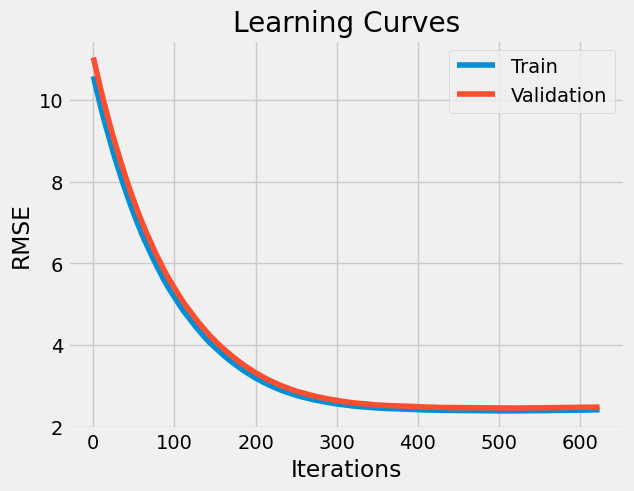

In [ ]:
train_results = reg.evals_result()['validation_0']['mape']
val_results = reg.evals_result()['validation_1']['mape']

plt.plot(range(len(train_results)), train_results, label='Train')
plt.plot(range(len(val_results)), val_results, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

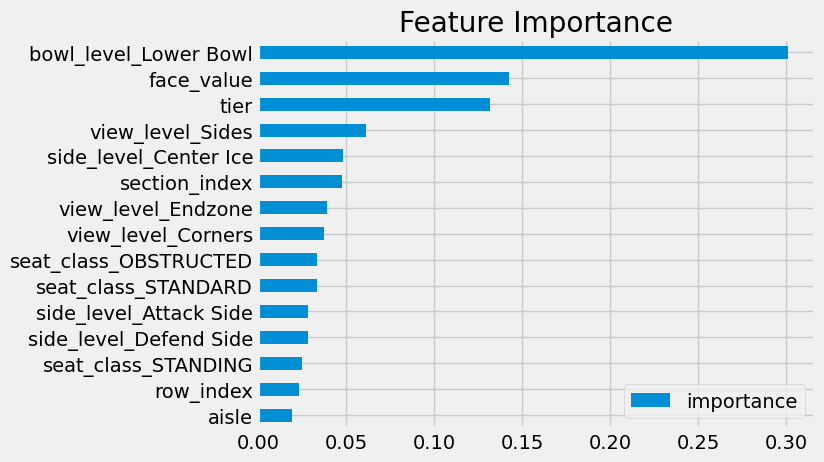

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)
test

,price_diff_perc,face_value,tier,section_index,row_index,bowl_level_Lower Bowl,aisle,bowl_level_Upper Bowl,view_level_Corners,view_level_Endzone,view_level_Sides,side_level_Attack Side,side_level_Center Ice,side_level_Defend Side,seat_class_OBSTRUCTED,seat_class_STANDARD,seat_class_STANDING,prediction
event_date,,,,,,,,,,,,,,,,,,
2022-03-17,-0.057269,227,5,0.642857,0.065789,True,False,False,False,True,False,False,False,True,False,True,False,-0.045055
2022-12-10,0.485075,134,3,1.000000,0.527778,False,False,True,True,False,False,False,False,True,False,True,False,0.195413
2023-02-24,0.117978,178,4,0.500000,0.391304,False,True,True,False,True,False,True,False,False,False,True,False,-0.034064
2017-12-19,0.807229,83,5,0.684211,0.235294,False,False,True,False,False,True,True,False,False,False,True,False,0.391373
2023-04-02,0.364198,162,4,0.529412,0.548387,False,True,True,True,False,False,False,False,True,False,True,False,0.016107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-29,-0.269874,478,3,0.148148,0.214286,True,False,False,True,False,False,True,False,False,False,True,False,-0.044869
2022-11-21,-0.240310,258,6,0.444444,0.333333,True,False,False,True,False,False,False,False,True,False,True,False,-0.012811
2016-11-15,-0.141104,163,5,1.107143,0.034483,True,True,False,False,True,False,False,False,True,False,True,False,0.016087


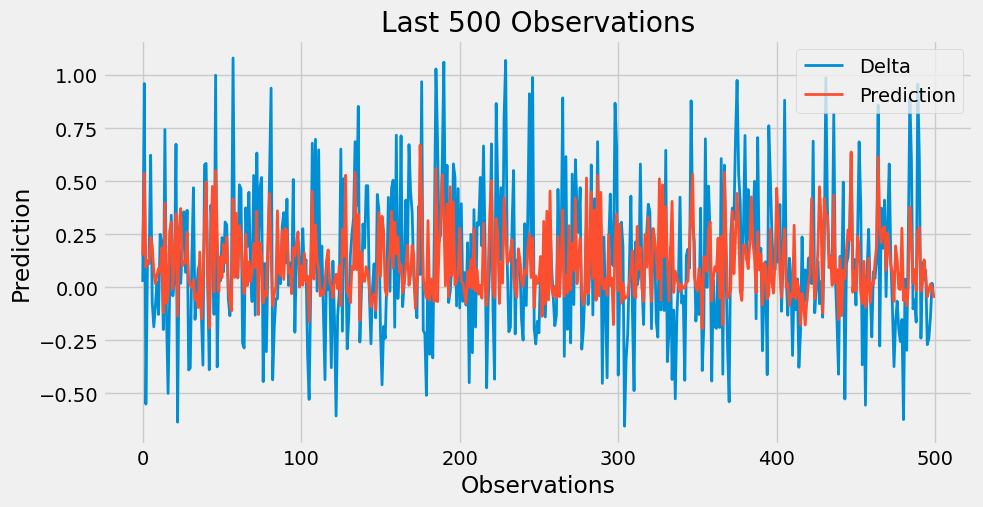

In [ ]:
# Filter the DataFrame for event_date of 2023
predictions_2023 = test[test.index.year == 2023]['price_diff_perc']

# Get the last 500 observations from the DataFrame
last_500 = test.tail(500)

# Plot the observations
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(last_500)), last_500['price_diff_perc'], label='Delta', linewidth=2)
ax.plot(range(len(last_500)), last_500['prediction'], label='Prediction', linewidth=2)
ax.set_xlabel('Observations')
ax.set_ylabel('Prediction')
ax.set_title('Last 500 Observations')
ax.legend()
plt.show()